In [243]:
import numpy as np 
import pandas as pd 
import os 
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from  torchvision import datasets ,transforms ,models
from torch.utils.data import random_split ,DataLoader
from torchvision.datasets import ImageFolder
from torch import optim
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as  plt
import warnings

warnings.filterwarnings('ignore')

In [244]:
neg_path = "/home/bhavit/Desktop/brain_tumor_detection/brain_tumor_dataset/no"
pos_path = "/home/bhavit/Desktop/brain_tumor_detection/brain_tumor_dataset/yes"

In [245]:
negative_files = os.listdir(neg_path)
negative_count = len(negative_files)

# Counting files in the positive directory
positive_files = os.listdir(pos_path)
positive_count = len(positive_files)

print("NO Tumor:", negative_count)
print("Tumor:", positive_count)

NO Tumor: 98
Tumor: 155


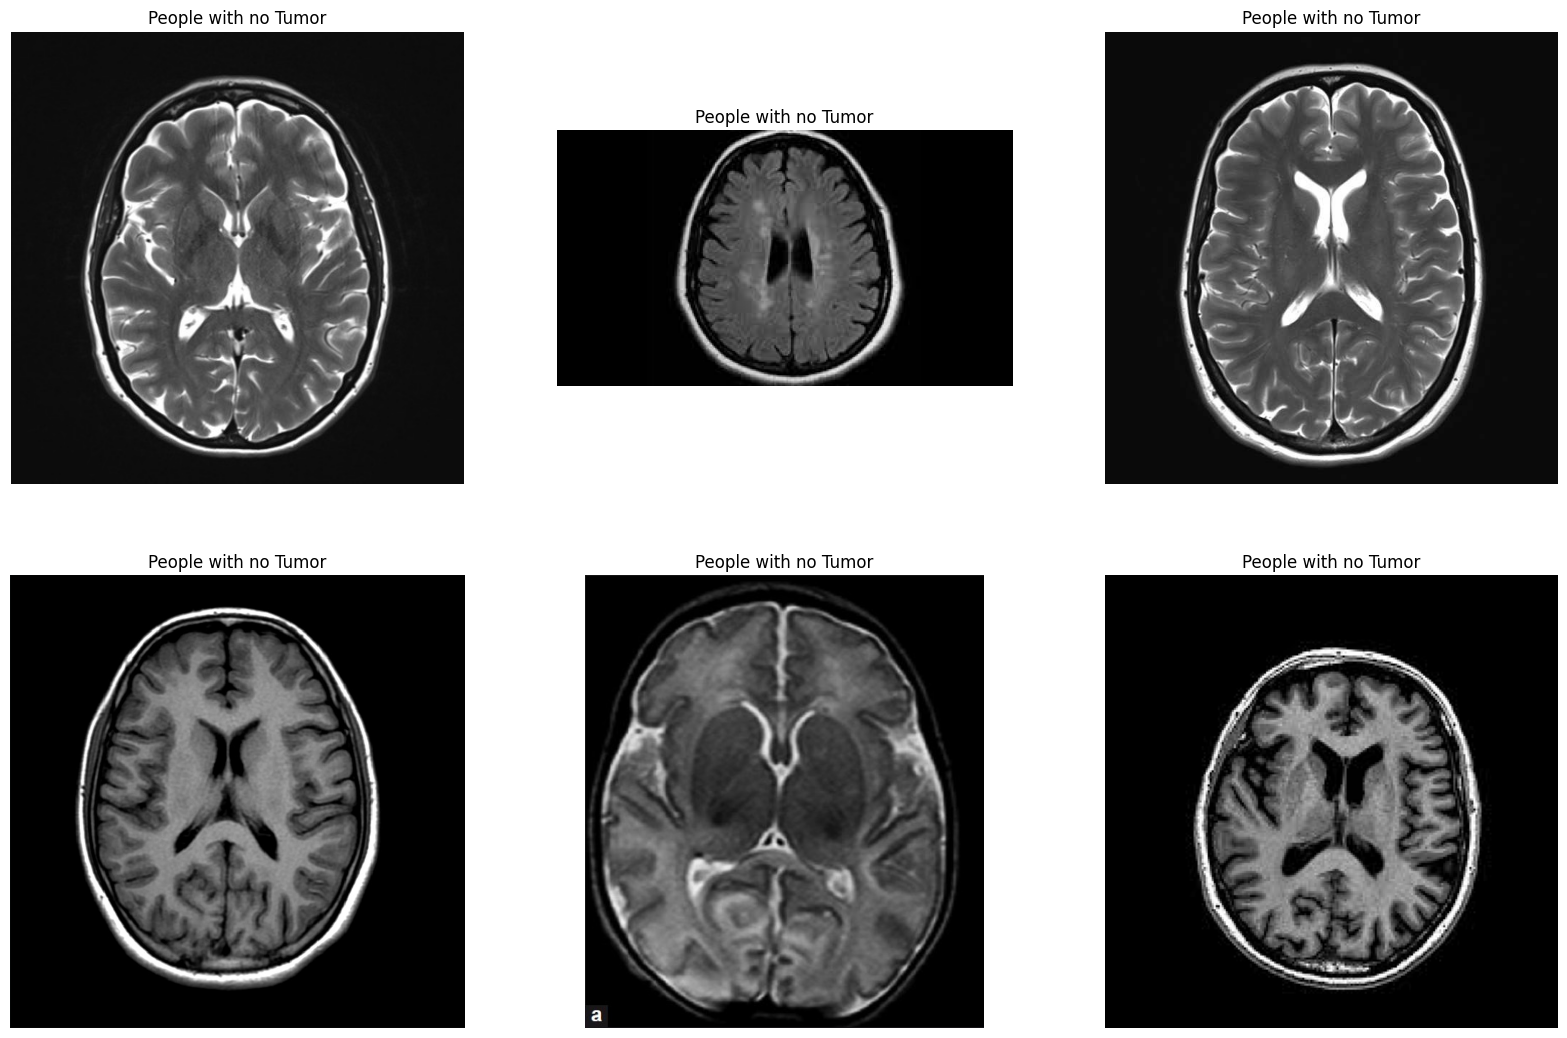

In [246]:
neg_files = os.listdir(neg_path)
fig = plt.figure(figsize=(20, 20))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join(neg_path, neg_files[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.imshow(img)
    plt.title("People with no Tumor")
    plt.axis('off') 
plt.show()

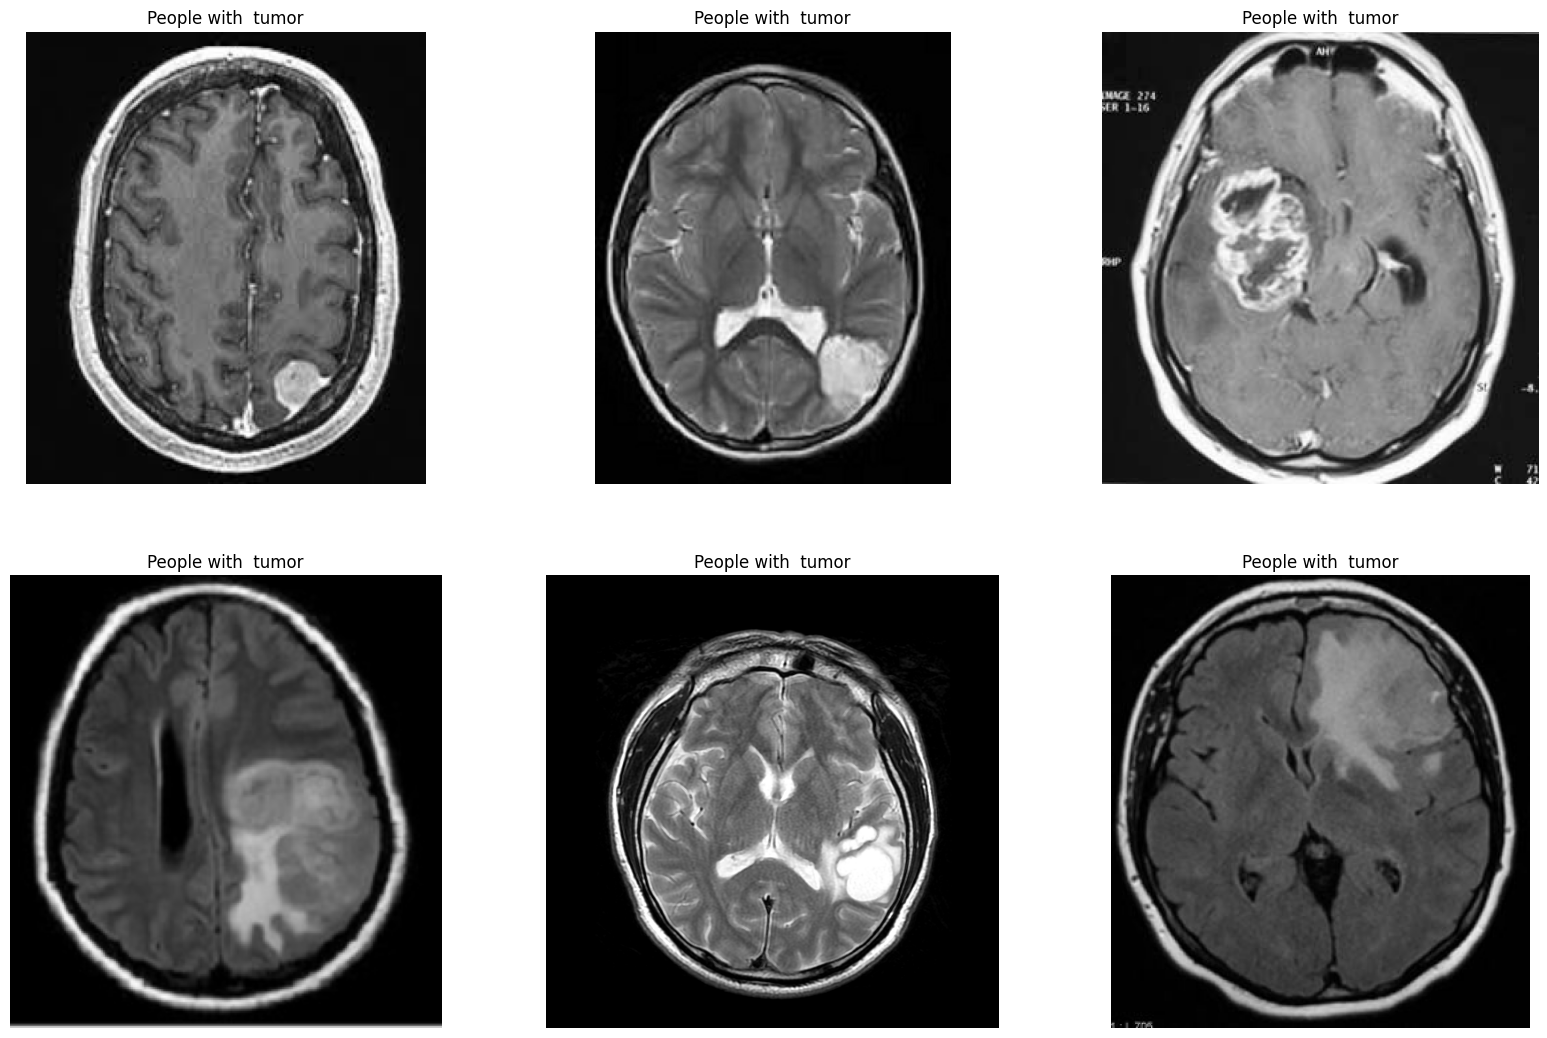

In [247]:
pos_file = os.listdir(pos_path)
fig = plt.figure(figsize=(20, 20))

for i in range(6):
    plt.subplot(3,3, i+1)
    image = os.path.join(pos_path ,positive_files[i])
    img = cv2.imread(image)
    plt.imshow(img)
    plt.title("People with  tumor")
    plt.axis("off")
plt.show()

In [248]:
def preprocess_data(data_set_path , batch_size = 32 , train_ratio = 0.8):
    transform  = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(p =0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std =[0.229, 0.224, 0.225])])
    
    
    #load the dataset 
    dataset = ImageFolder(data_set_path ,transform=transform)

    # Split the dataset into training and validation sets
    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Print the classes
    print(dataset.classes)

    return train_loader, val_loader
    

In [249]:
train_loader ,test_loader = preprocess_data("/home/bhavit/Desktop/brain_tumor_detection/brain_tumor_dataset")

['no', 'yes']


Making cnn mode

In [250]:
class Brain_tumor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,2,1)
        self.conv2 = nn.Conv2d(32,16,2,1)
        self.maxpool = nn.MaxPool2d(2,2)
        self.flat = nn.Flatten()
        self.conv_total = nn.Sequential(
            self.conv1,
            self.maxpool,
            self.conv2,
            self.maxpool
        )

        self.linear1 = nn.Linear(48400,74)
        self.linear2 = nn.Linear(74,2)

    def forward(self ,x):
        x = F.relu(self.conv_total(x))
        x = self.flat(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))

        return F.log_softmax(x ,dim = 1)


In [251]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [252]:
model = Brain_tumor()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr =0.001)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in the model: {total_params}")

Total parameters in the model: 3584304


In [253]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

EPOCH = 10
for epoch in range(EPOCH):
    train_loss = 0.0
    val_loss = 0.0
    correct_train = 0
    total_train = 0
    correct_val = 0
    total_val = 0

    # Training
    model.train()
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCH} - Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(output.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accs.append(train_accuracy)

    # Validation
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCH} - Validation"):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(output.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accs.append(val_accuracy)

    print(f"EPOCH {epoch+1}/{EPOCH}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print("======================================================")
    print('\t')


Epoch 1/10 - Validation: 100%|██████████| 2/2 [00:00<00:00, 14.41it/s]


EPOCH 1/10, Train Loss: 1.5003, Train Accuracy: 60.40%, Validation Loss: 0.6226, Validation Accuracy: 80.39%
	


Epoch 2/10 - Validation: 100%|██████████| 2/2 [00:00<00:00, 19.11it/s]


EPOCH 2/10, Train Loss: 0.4182, Train Accuracy: 82.67%, Validation Loss: 0.5594, Validation Accuracy: 76.47%
	


Epoch 3/10 - Validation: 100%|██████████| 2/2 [00:00<00:00, 12.17it/s]


EPOCH 3/10, Train Loss: 0.3887, Train Accuracy: 85.64%, Validation Loss: 0.6258, Validation Accuracy: 76.47%
	


Epoch 4/10 - Validation: 100%|██████████| 2/2 [00:00<00:00, 19.06it/s]


EPOCH 4/10, Train Loss: 0.3330, Train Accuracy: 84.65%, Validation Loss: 0.5289, Validation Accuracy: 80.39%
	


Epoch 5/10 - Validation: 100%|██████████| 2/2 [00:00<00:00, 19.20it/s]


EPOCH 5/10, Train Loss: 0.2752, Train Accuracy: 91.09%, Validation Loss: 0.6008, Validation Accuracy: 78.43%
	


Epoch 6/10 - Validation: 100%|██████████| 2/2 [00:00<00:00, 14.73it/s]


EPOCH 6/10, Train Loss: 0.2201, Train Accuracy: 92.57%, Validation Loss: 0.6131, Validation Accuracy: 82.35%
	


Epoch 7/10 - Validation: 100%|██████████| 2/2 [00:00<00:00, 18.38it/s]


EPOCH 7/10, Train Loss: 0.1553, Train Accuracy: 94.55%, Validation Loss: 0.6563, Validation Accuracy: 84.31%
	


Epoch 8/10 - Validation: 100%|██████████| 2/2 [00:00<00:00, 12.47it/s]


EPOCH 8/10, Train Loss: 0.1281, Train Accuracy: 96.04%, Validation Loss: 0.6557, Validation Accuracy: 82.35%
	


Epoch 9/10 - Validation: 100%|██████████| 2/2 [00:00<00:00, 19.01it/s]


EPOCH 9/10, Train Loss: 0.0990, Train Accuracy: 97.03%, Validation Loss: 0.6450, Validation Accuracy: 82.35%
	


Epoch 10/10 - Validation: 100%|██████████| 2/2 [00:00<00:00, 11.32it/s]

EPOCH 10/10, Train Loss: 0.0714, Train Accuracy: 99.01%, Validation Loss: 0.7364, Validation Accuracy: 78.43%
	
